In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the URL of the page to scrape
url = "https://www.the-numbers.com/box-office-records/domestic/all-movies/biggest-weekend-by-month/october"

# Define a custom user agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"

# Create headers with the custom user agent
headers = {
    "User-Agent": user_agent
}

# Send a GET request to the URL with custom headers
response = requests.get(url, headers=headers)

In [3]:
# Parse the HTML content of the page
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the movie list
table = soup.select('#page_filling_chart > center > table')[0]

# Initialize empty lists to store movie data
movie_data = []

# Loop through each row in the table (skip the header row)
for row in table.find_all('tr')[1:]:
    columns = row.find_all('td')
    if len(columns) == 8:  # Ensure that the row has all the expected columns
        rank = columns[0].get_text(strip=True)
        release_date = columns[1].get_text(strip=True)
        title = columns[2].find('a').get_text(strip=True)
        url = columns[2].find('a').get('href')
        domestic_box_office = columns[3].get_text(strip=True)
        movie_data.append([rank, release_date, title, url, domestic_box_office])

# Create a DataFrame from the movie data
df = pd.DataFrame(movie_data, columns=['Rank', 'Date', 'Movie', 'URL', 'Gross'])

# Save the DataFrame to a CSV file
df.to_csv("movie_list.csv", index=False)



In [4]:
df.head()

,Rank,Date,Movie,URL,Gross
0,1,"Oct 4, 2019",Joker,/movie/Joker-(2019)#tab=summary,"$96,202,337"
1,2,"Oct 1, 2021",Venom: Let There be Carnage,/movie/Venom-Let-There-be-Carnage#tab=summary,"$90,033,210"
2,3,"Oct 5, 2018",Venom,/movie/Venom-(2018)#tab=summary,"$80,255,756"
3,4,"Oct 19, 2018",Halloween,/movie/Halloween-(2018)#tab=summary,"$76,221,545"
4,5,"Oct 21, 2022",Black Adam,/movie/Black-Adam-(2022)#tab=summary,"$67,004,323"


In [5]:
def scrape_movie(url):
    movie_response = requests.get(f'https://www.the-numbers.com{url}', headers=headers)

    # Parse the HTML content of the page
    soup = BeautifulSoup(movie_response.text, 'html.parser')

    # Find the table with the specified selector
    tables = soup.select('#box_office_chart > table')
    table = tables[1]

    # Initialize empty lists to store table data
    table_data = []

    # Loop through each row in the table
    for row in table.find_all('tr'):
        columns = row.find_all('td')
        row_data = [col.get_text(strip=True) for col in columns]

        if len(row_data) > 0 and row_data[1] != "P":
            table_data.append(row_data)

    # Create a DataFrame from the table data
    df = pd.DataFrame(table_data, columns=['Date', 'Rank', 'Gross',	'%YD', '%LW', 'Theaters', 'Per Theater', 'Total Gross', 'Days'])

    return df



In [6]:
data = {}

for index, row in df.iterrows():
    print(index, row['Movie'], row['URL'])
    data[row['Movie']] = scrape_movie(row['URL'])

0 Joker /movie/Joker-(2019)#tab=summary
1 Venom: Let There be Carnage /movie/Venom-Let-There-be-Carnage#tab=summary
2 Venom /movie/Venom-(2018)#tab=summary
3 Halloween /movie/Halloween-(2018)#tab=summary
4 Black Adam /movie/Black-Adam-(2022)#tab=summary
5 Joker /movie/Joker-(2019)#tab=summary
6 Gravity /movie/Gravity#tab=summary
7 No Time to Die /movie/No-Time-to-Die-(2021)#tab=summary
8 The Martian /movie/Martian-The#tab=summary
9 Paranormal Activity 3 /movie/Paranormal-Activity-3#tab=summary
10 Jackass 3D /movie/Jackass-3D#tab=summary
11 Taken 2 /movie/Taken-2#tab=summary
12 Halloween Kills /movie/Halloween-Kills-(2021)#tab=summary
13 Scary Movie 3 /movie/Scary-Movie-3#tab=summary
14 Shark Tale /movie/Shark-Tale#tab=summary
15 Gravity /movie/Gravity#tab=summary
16 A Star is Born /movie/Star-is-Born-A-(2018)#tab=summary
17 High School Musical 3: Senior Year /movie/High-School-Musical-3-Senior-Year#tab=summary
18 Dune /movie/Dune-(2020)#tab=summary
19 Paranormal Activity 2 /movie/Paran

In [7]:
clean_data = []

def dval(s):
    return float(s.replace("$", "").replace(",", ""))

for movie_name in data:
    d1 = data[movie_name].iloc[0]['Gross']
    d2 = data[movie_name].iloc[1]['Gross']
    d3 = data[movie_name].iloc[2]['Gross']
    clean_data.append([movie_name, dval(d1), dval(d2), dval(d3)])

clean_data = [d for d in clean_data if (sum(d[1:]) / (d[1])) < 6]

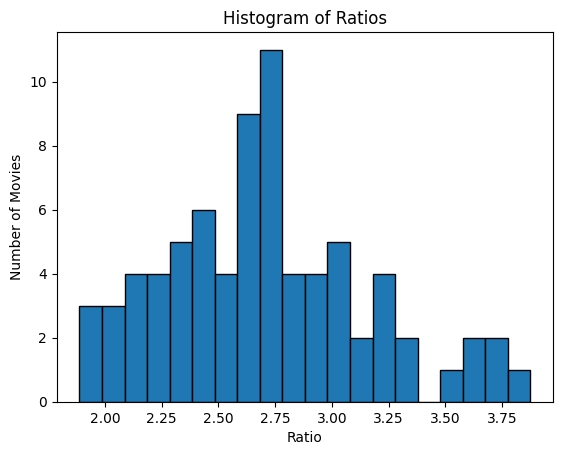

In [8]:
import matplotlib.pyplot as plt
# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=20, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number of Movies')
plt.title('Histogram of Ratios')
plt.show()


In [9]:
# Compute ratios
ratios = [(sum(movie[1:]) / movie[1]) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > 2.5)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


The probability that the ratio exceeds 2.5 is 67.11%


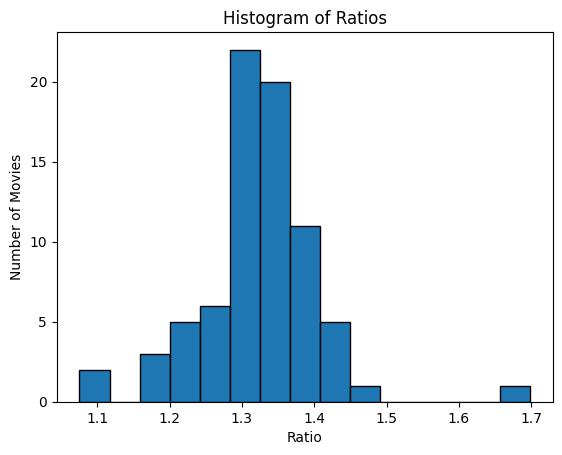

In [10]:
ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=15, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number of Movies')
plt.title('Histogram of Ratios')
plt.show()


In [11]:
DAY_1_EARNINGS = 40 # mm

ratio_bound = 125/(DAY_1_EARNINGS)

# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > ratio_bound)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


The probability that the ratio exceeds 2.5 is 15.79%


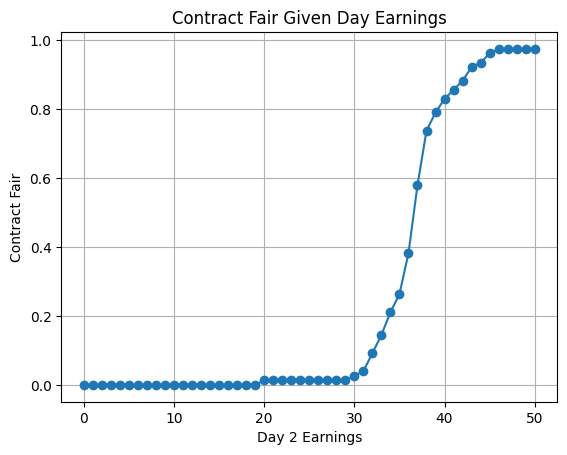

In [12]:

DAY_1_EARNINGS = 39  # mm

def calculate_probability(DAY_2_EARNINGS):
    ratio_bound = 100 / (DAY_1_EARNINGS + DAY_2_EARNINGS)
    ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]
    count_exceeding_bound = sum(1 for ratio in ratios if ratio > ratio_bound)
    return count_exceeding_bound / len(ratios)

# Get the probabilities for each value of DAY_2_EARNINGS from 0 to 50
probabilities = [calculate_probability(i) for i in range(51)]

# Plot
plt.plot(range(51), probabilities, marker='o', linestyle='-')
plt.xlabel('Day 2 Earnings')
plt.ylabel('Contract Fair')
plt.title('Contract Fair Given Day Earnings')
plt.grid(True)
plt.show()

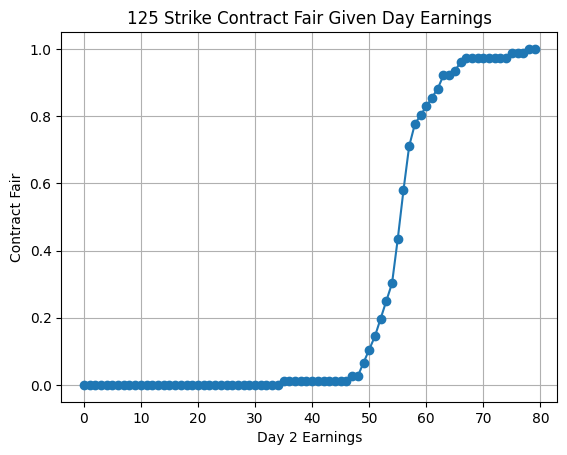

In [13]:

DAY_1_EARNINGS = 39  # mm

def calculate_probability(DAY_2_EARNINGS):
    ratio_bound = 125 / (DAY_1_EARNINGS + DAY_2_EARNINGS)
    ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]
    count_exceeding_bound = sum(1 for ratio in ratios if ratio > ratio_bound)
    return count_exceeding_bound / len(ratios)

# Get the probabilities for each value of DAY_2_EARNINGS from 0 to 50
probabilities = [calculate_probability(i) for i in range(80)]

# Plot
plt.plot(range(80), probabilities, marker='o', linestyle='-')
plt.xlabel('Day 2 Earnings')
plt.ylabel('Contract Fair')
plt.title('125 Strike Contract Fair Given Day Earnings')
plt.grid(True)
plt.show()

In [14]:
DAY_1_EARNINGS = 39

ratio_bound = 125/(DAY_1_EARNINGS)

# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > ratio_bound)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


The probability that the ratio exceeds 2.5 is 13.16%


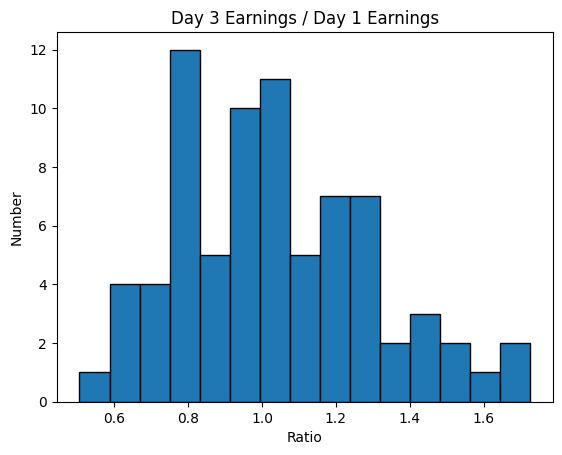

In [15]:
import matplotlib.pyplot as plt
# Compute ratios
ratios = [movie[2] / movie[1] for movie in clean_data]

# Plot histogram
plt.hist(ratios, bins=15, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Number')
plt.title('Day 3 Earnings / Day 1 Earnings')
plt.show()


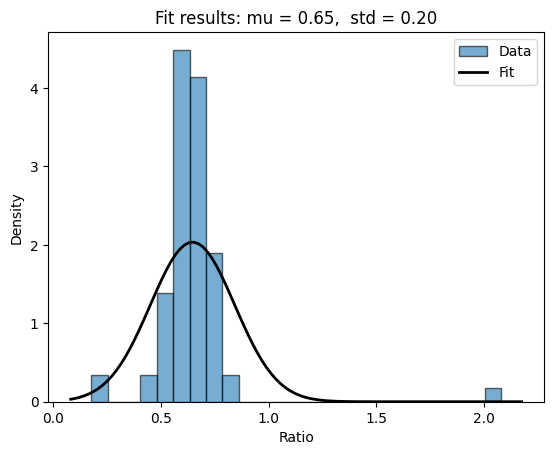

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming clean_data is already defined
ratios = [movie[3] / movie[2] for movie in clean_data]

# Estimate the parameters of the normal distribution
mu, std = norm.fit(ratios)

# Plot histogram
plt.hist(ratios, bins=25, edgecolor='black', density=True, alpha=0.6, label="Data")

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label="Fit")

# Set title and labels
plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")
plt.xlabel('Ratio')
plt.ylabel('Density')
plt.legend()

plt.show()


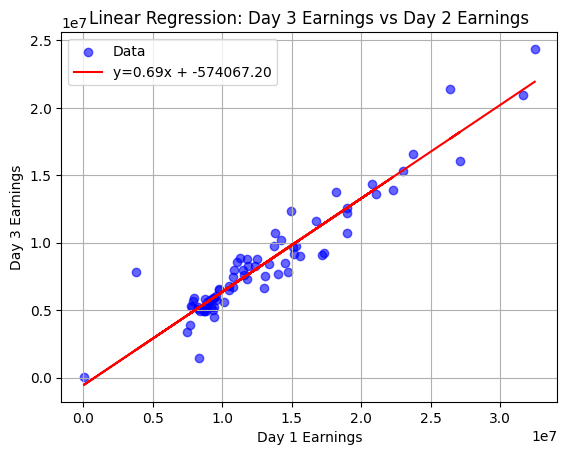

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming clean_data is already defined
day2_earnings = [movie[2] for movie in clean_data]
day3_earnings = [movie[3] for movie in clean_data]

# Linear regression
slope, intercept = np.polyfit(day2_earnings, day3_earnings, 1)

# Scatter plot
plt.scatter(day2_earnings, day3_earnings, label='Data', color='blue', alpha=0.6)

# Plot regression line
x = np.array(day2_earnings)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'y={slope:.2f}x + {intercept:.2f}')

# Set title and labels
plt.title('Linear Regression: Day 3 Earnings vs Day 2 Earnings')
plt.xlabel('Day 1 Earnings')
plt.ylabel('Day 3 Earnings')
plt.legend()
plt.grid(True)

plt.show()


In [18]:
from sklearn.linear_model import LinearRegression

# Assuming clean_data is already defined
day1_earnings = [movie[1] for movie in clean_data]
day2_earnings = [movie[2] for movie in clean_data]
day3_earnings = [movie[3] for movie in clean_data]

# Reshape the data and prepare the feature matrix X and target vector y
X = list(zip(day1_earnings, day2_earnings))
y = day3_earnings

# Create and fit the model
model = LinearRegression().fit(X, y)

# Print coefficients
print(f"a1 (coefficient for Day 1 Earnings): {model.coef_[0]:.2f}")
print(f"a2 (coefficient for Day 2 Earnings): {model.coef_[1]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")


a1 (coefficient for Day 1 Earnings): -0.01
a2 (coefficient for Day 2 Earnings): 0.71
Intercept: -584332.94


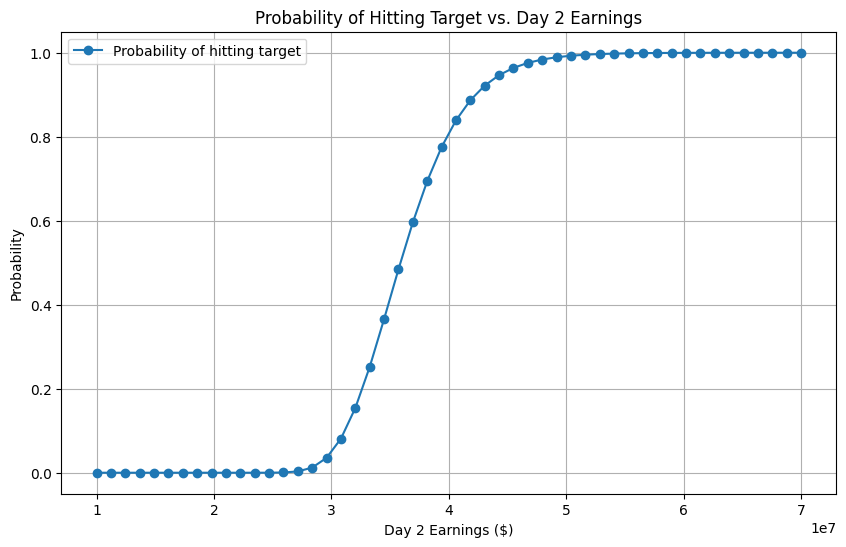

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def get_target(day_2_earnings):
    # target ratio day 3 / day 2 to hit 100mm
    target = (100e6 - 39e6 - day_2_earnings) / day_2_earnings
    return target

def prob_hitting_target(target):
    mu = 0.7
    sigma = 0.2
    return 1 - norm.cdf(target, mu, sigma)

x_vals = np.linspace(10000000, 70000000, 50)
y_vals = [prob_hitting_target(get_target(x)) for x in x_vals]

plt.figure(figsize=(10,6))
plt.plot(x_vals, y_vals, '-o', label='Probability of hitting target')
plt.xlabel('Day 2 Earnings ($)')
plt.ylabel('Probability')
plt.title('Probability of Hitting Target vs. Day 2 Earnings')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Compute ratios
ratios = [(sum(movie[1:]) / (movie[1] + movie[2])) for movie in clean_data]

# Count the occurrences where the ratio exceeds 2.5
count_exceeding_2_5 = sum(1 for ratio in ratios if ratio > 1.39)

# Calculate the probability
probability = count_exceeding_2_5 / len(ratios)

print(f"The probability that the ratio exceeds 2.5 is {probability:.2%}")


for movie in clean_data:
    if (sum(movie[1:]) / (movie[1] + movie[2])) > 1.39:
        print(movie[0])


The probability that the ratio exceeds 2.5 is 14.47%
Shark Tale
A Star is Born
Puss in Boots
Hotel Transylvania 2
The Addams Family
Beverly Hills Chihuahua
Meet the Parents
Real Steel
Hotel Transylvania
Michael Jackson's This Is It
Cloudy with a Chance of Meatballs 2
